In [1]:
import torch

import matplotlib.pyplot as plt
import numpy as np

from sparsecoding.data.datasets.field import FieldDataset
from sparsecoding import inference

from sparsecoding import models
from sparsecoding.visualization import plot_dictionary

/home/alvinz/sparsecoding_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Define constants and load data

In [2]:
data_dir = "data/raw"
patch_size = 16

field_dataset = FieldDataset(
    root=data_dir,
    patch_size=patch_size,
)

In [3]:
data = field_dataset.patches.type(torch.float32).reshape(-1, patch_size**2)

n_samples, n_features = data.shape

### Visualize patches

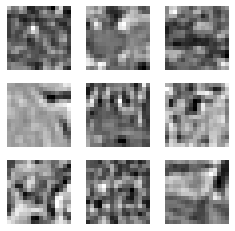

In [4]:
figure = plt.figure(figsize=(4,4))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(data), size=(1,)).item()
    img = (data[sample_idx])
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze().reshape([patch_size, patch_size]), cmap="gray")
plt.show()

### Sparse Coding via Dictionary Learning

In [5]:
### DEFINE MODEL
lca = inference.LCA(coeff_lr=1e-3,threshold=0.1,n_iter=300)
sc = models.SparseCoding(inference_method=lca,n_basis=n_features,n_features=n_features,dictionary_lr=1e-1)

<IPython.core.display.Javascript object>


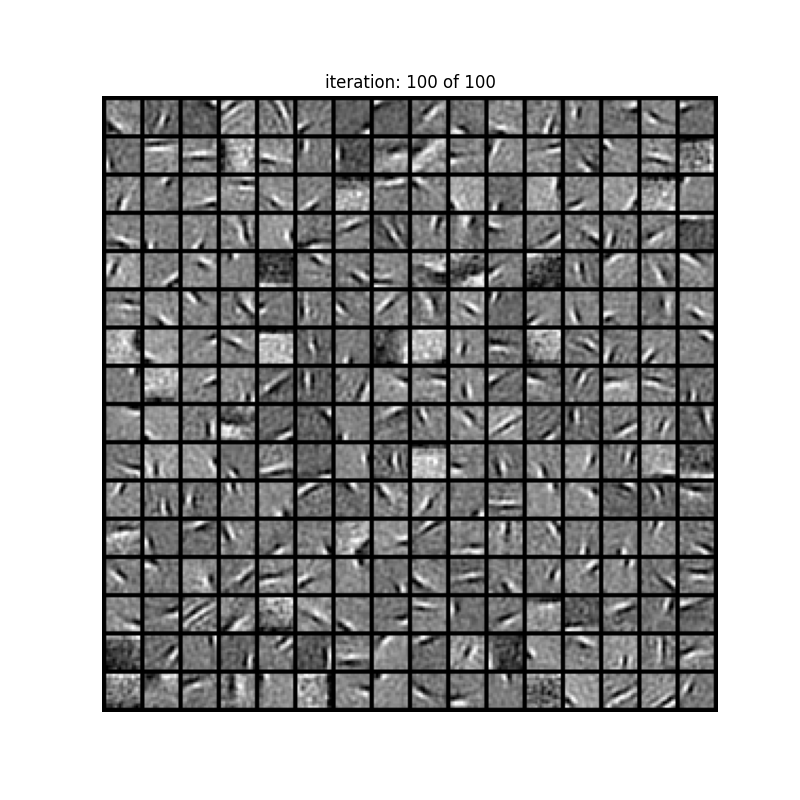

In [6]:
%matplotlib notebook

n_epoch = 100
montage_update_rate = 10

# Plot Updates
nrow = 16
fig,ax = plot_dictionary(sc.dictionary,nrow=nrow)

losses = np.array([])

for i in range(n_epoch//montage_update_rate):
    # learn dictionary
    loss = sc.learn_dictionary(dataset=data,n_epoch=n_epoch,batch_size=500)
    losses = np.concatenate([losses,loss])
    # update montage
    fig,ax = plot_dictionary(sc.dictionary,fig=fig,ax=ax,title='iteration: %d of %d'%(i*montage_update_rate,n_epoch),nrow=nrow)

fig,ax = plot_dictionary(sc.dictionary,fig=fig,ax=ax,title='iteration: %d of %d'%(n_epoch,n_epoch),nrow=nrow)

<IPython.core.display.Javascript object>


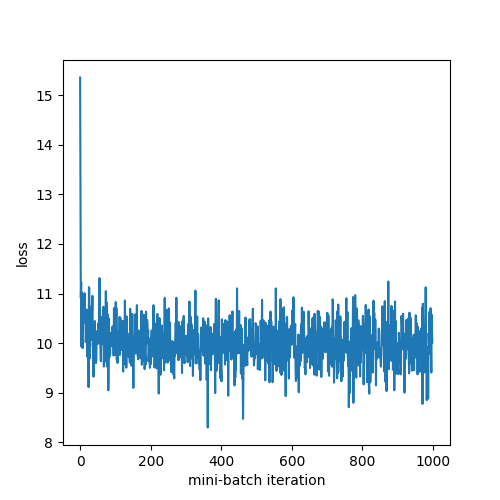

In [8]:
fig,ax = plt.subplots(figsize=(5,5))
ax.plot(losses)
ax.set_xlabel('mini-batch iteration')
ax.set_ylabel('loss')
plt.show()